<a href="https://colab.research.google.com/github/hajmolafury/svhn/blob/master/svhn_grayscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Import necessary libraries
👇🏻 cell : Tensorflow, Plotly (for interactive plots), Matplotlib (for showing images from matrix), etc.



In [0]:
import time
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.io as sio
from scipy.misc import *
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
plotly.tools.set_credentials_file(username='ymehta95', api_key='TVHPG5E24omQeUyWougP')
import plotly.plotly as py
import plotly.graph_objs as go

%matplotlib inline
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

####Google Drive Access
👇🏻 cell : Gives our Colab notebook access to data present in Google Drive. The SVHN dataset is uploaded on Drive and the Google Server which hosts this notebook takes input from the Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


####Data load & preprocessing
👇🏻 cell : loads the training and testing images from Google Drive. Preprocessing involves changing the data tensor into the shape we want as well as converting all the images to grayscale and flattening them. We also convert the labels (y) to one-hot encoding matrix.

In [0]:
file_path='/content/drive/My Drive/clouderizer/Clouderizer-svhn/data'

def __store_data(data, num_of_examples):
    d = []

    for i in range(num_of_examples):
        d.append(data[:, :, :, i])

    return np.asarray(d)
  
def rgb2gray(rgb):
  return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


train = sio.loadmat(file_path + "/train_32x32.mat")
y_train = train['y']
train_examples = train['X'].shape[3]
x_train = __store_data(train['X'].astype("float32"), train_examples)
x_train=x_train/255
rgbx_train=x_train
x_train=rgb2gray(x_train)
grayx_train=x_train
x_train=tf.Session().run(tf.reshape(grayx_train, [train_examples,1024]))


test = sio.loadmat(file_path+"/test_32x32.mat")
y_test = test['y']
test_examples = test['X'].shape[3]
x_test = __store_data(test['X'].astype("float32"), test_examples)
x_test=x_test/255
rgbx_test=x_test
x_test=rgb2gray(x_test)
grayx_test=x_test
x_test=tf.Session().run(tf.reshape(grayx_test, [test_examples,1024]))

coldy_train=y_train
coldy_test=y_test
# coldy_train=tf.Session().run(tf.reshape(coldy_train, [train_examples]))
# coldy_test=tf.Session().run(tf.reshape(coldy_test, [test_examples]))

y_train=tf.Session().run(tf.reshape(tf.Session().run(tf.one_hot(coldy_train,depth=11)),[train_examples,n_classes]))
y_test=tf.Session().run(tf.reshape(tf.Session().run(tf.one_hot(coldy_test,depth=11)),[test_examples,n_classes]))

####Verify Data
👇🏻 cell : check if the data has been loaded and if the grayscale conversion is working as planned.

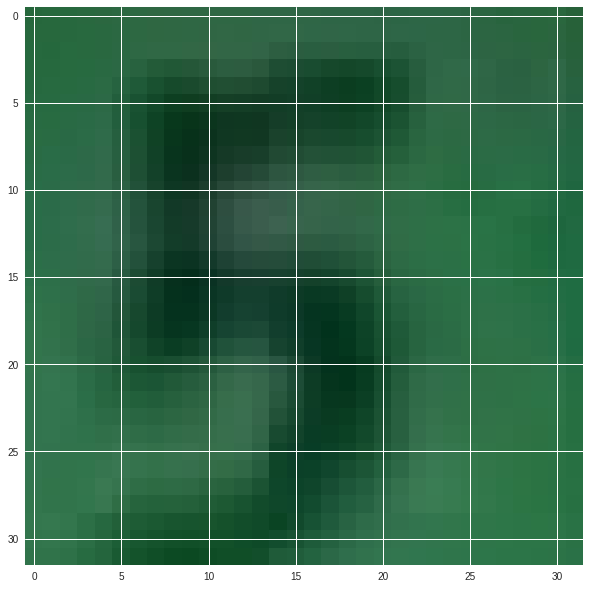

In [36]:
img=rgbx_test[0]
plt.figure(figsize=(10,20))
plt.imshow(img)

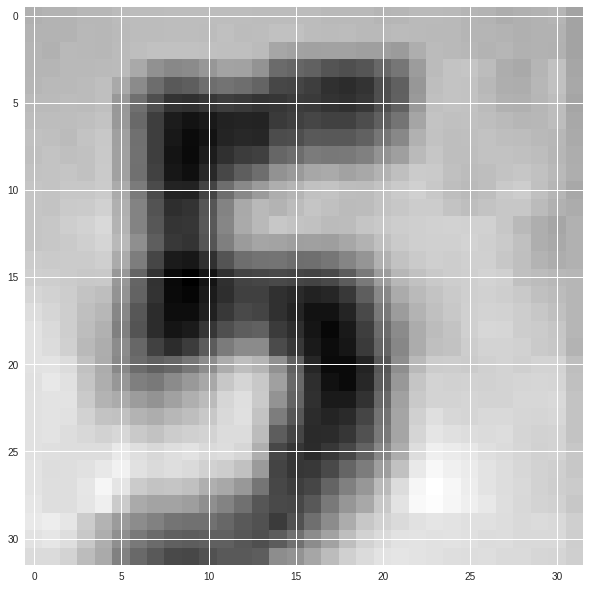

In [37]:
img=grayx_test[0]
plt.figure(figsize=(10,20))
plt.imshow(img, cmap='gray')

####Define network architecture
👇🏻 cell : we define the number of hidden layers, the nodes in each of the layers, which activation function should be used, weight initialization; basically set all the 'parameters' of the network.

In [0]:
nodes_hl1=1000
nodes_hl2=1000
n_classes=11

x=tf.placeholder('float',[None,1024])
y=tf.placeholder('float')


def neural_network(data):
  
    #initializer= tf.contrib.layers.xavier_initializer()
    initializer=tf.keras.initializers.he_normal()
    
    hl1={'weights':tf.Variable(initializer([1024,nodes_hl1])),'bias':tf.Variable(initializer([nodes_hl1]))}
    hl2={'weights':tf.Variable(initializer([nodes_hl1,nodes_hl2])),'bias':tf.Variable(initializer([nodes_hl2]))}
    output_layer={'weights':tf.Variable(initializer([nodes_hl2,n_classes])),'bias':tf.Variable(initializer([n_classes]))}
    
    
    l1=tf.add(tf.matmul(data,hl1['weights']),hl1['bias'])
    l1=tf.nn.relu(l1)
                                                                                        
    l2=tf.add(tf.matmul(l1,hl2['weights']),hl2['bias'])
    l2=tf.nn.relu(l2)
                                                                                           
    output=tf.nn.sigmoid(tf.add(tf.matmul(l2,output_layer['weights']),output_layer['bias']))
                                                                                           
    return output

####Training!
👇🏻 cell : run the tf session feeding training data in mini-batches. Here we define the loss function of the network along with the optimizer. We continuously keep saving the loss and accuracies as the network gets trained so that we may plot them later.

In [0]:
def train_neural_network(optimizer):
    prediction=neural_network(x)
    prediction=tf.nn.softmax(prediction)
    
    loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction,labels=y))
    
    if optimizer=='adam':
        optimize=tf.train.AdamOptimizer(learning_rate=0.00015).minimize(loss)
    if optimizer=='sgd':
        optimize=tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)
        
   
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(num_epoch):
            for i in range(0, train_examples, batch_size):
                # Get pair of (X, y) of the current minibatch/chunk
                batch_x = x_train[i:i + batch_size]
                batch_y = y_train[i:i + batch_size]
                _, l=sess.run([optimize, loss],feed_dict={x:batch_x,y:batch_y})
                epoch_loss[epoch]+=l
                
                
            correct=tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
            accuracy=tf.reduce_mean(tf.cast(correct,'float'))
            test_acc.append(accuracy.eval({x:x_test,y:y_test}))
              

            print ('Epoch', epoch+1,'completed out of',num_epoch,'loss:',epoch_loss[epoch])            
            print ('Test Accuracy :', test_acc[-1])
            print (time.time() - start_time, 'sec')
            if (epoch-9)%10 == 0:
                print()
                train_acc.append(accuracy.eval({x:x_train,y:y_train}))
                print('Training Accuracy :', train_acc[-1])
                
                

####Main Function
👇🏻 cell : calls the network training function and sets training parameters like number of epochs and mini-batch size. First we train the network using **Adam Optimizer.**

In [30]:
num_epoch=150
batch_size=128
epoch_loss=np.zeros(num_epoch)
test_acc=[]
train_acc=[]

if __name__=="__main__":
    start_time=time.time()
    train_neural_network('adam')
    print ("\nThe network has been trained!")

Epoch 1 completed out of 150 loss: 1362.7428612709045
Test Accuracy : 0.18273664
4.30288028717041 sec
Epoch 2 completed out of 150 loss: 1357.500561952591
Test Accuracy : 0.26025662
7.3076512813568115 sec
Epoch 3 completed out of 150 loss: 1350.3734245300293
Test Accuracy : 0.37019822
10.202640533447266 sec
Epoch 4 completed out of 150 loss: 1344.768884897232
Test Accuracy : 0.47883373
13.06562066078186 sec
Epoch 5 completed out of 150 loss: 1341.647728919983
Test Accuracy : 0.4973494
15.931823492050171 sec
Epoch 6 completed out of 150 loss: 1340.667802810669
Test Accuracy : 0.49792564
18.790384531021118 sec
Epoch 7 completed out of 150 loss: 1340.0499880313873
Test Accuracy : 0.5062999
21.652152061462402 sec
Epoch 8 completed out of 150 loss: 1339.5411159992218
Test Accuracy : 0.5091426
24.484244108200073 sec
Epoch 9 completed out of 150 loss: 1339.198301076889
Test Accuracy : 0.5137139
27.337333917617798 sec
Epoch 10 completed out of 150 loss: 1338.8549354076385
Test Accuracy : 0.515

####Create Plots
👇🏻 cell : creates plots for loss, training and testing accuracies wrt epoch number using Plotly.

In [41]:
x_axis0=np.arange(num_epoch)
x_axis1=np.arange(10,num_epoch,10)

trace0=go.Scatter(x=x_axis0,y=epoch_loss,mode='lines',name='loss')
trace1=go.Scatter(x=x_axis0,y=test_acc,mode='lines',name='test_acc')
trace2=go.Scatter(x=x_axis1,y=train_acc,mode='lines+markers',name='train_acc')

data=([trace0])
py.iplot(data,filename='svhn_adam_loss')

In [42]:
data=([trace1,trace2])
py.iplot(data,filename='svhn_adam_acc')

In [0]:
num_epoch=150
epoch_loss=np.zeros(num_epoch)
test_acc=[]
train_acc=[]

if __name__=="__main__":
    start_time=time.time()
    train_neural_network(x,'sgd')
    print ("\nThe network has been trained!")

In [0]:
trace0=go.Scatter(x=x_axis1,y=epoch_loss)
trace1=go.Scatter(x=x_axis2,y=test_acc)
trace2=go.Scatter(x=x_axis3,y=train_acc)
data=([trace0])
py.iplot(data,filename='svhn_sgd_loss')

In [0]:
data=([trace1,trace2])
py.iplot(data,filename='svhn_sgd_acc')